In [1]:
# use segment cluster to optimize for jet/muon veto PT cuts

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.22/02
3.6.8 (default, Apr  2 2020, 13:34:55) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()


start_t = time.time()
data_year = 'full'
pdgId = 13
category = 0
OLD_CTAU = 100 #cm



ntupler_version = 'V1p17/'
analyzer_version = 'v1/v6/' 
mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Summer16/'+analyzer_version+'/normalized/'
fpath_bkg['bkg'] = mc_path + 'WJetsToLNu_HT-70ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fpath_bkg['signal'] = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/scripts/signal.root' #hadd of all signal ggh->bb v1/v6
lumi = 137000


NEvents = {}
print(data_year, lumi/1000)
NEvents_genweight = {}
for k,v in fpath_bkg.items():
    print (k, v)
   
    root_dir = uproot.open(v) 

    tree_bkg[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
#     tree[k] = root_dir['ntuples']
    a = tree_bkg[k]["weight"].array()
    print("NEvents",NEvents[k])


    print ('weights',np.unique(a)*lumi)
    print(np.sum(a)*lumi)
    print(len(a))



full 137.0
bkg /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_Summer16/v1/v6//normalized/WJetsToLNu_HT-70ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root
NEvents 171636960.0
weights [2.08722918e-03 3.20567849e-02 1.12514733e-01 1.16454453e-01
 1.09996940e+00 1.50384537e+00 2.80531441e+00]
8300.06380006671
50735
signal /storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/scripts/signal.root


FileNotFoundError: [Errno 2] No such file or directory: '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/scripts/signal.root'

# Load trigger

In [3]:
trigger_names_file = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
# if wH:
#     trigger_paths = [87,135,136] #PFMET120
# #     elif data_year == 2017: trigger_paths = [87,136] #PFMET120
# else:
trigger_paths = [177,362,87,135,136] #PFMET120
trigger_paths += [84,91]
if category == 0:
    trigger_paths = [310]


# load bdt

In [4]:
# make predictions for test data

import pickle
# model = pickle.load(open( 'bdt_flatten_noEvtSelection.pickle.dat', "rb" ))
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v12'
model = pickle.load(open( bdt_name+'.pickle', "rb" ))
y_pred = model.predict_proba([1,2,3,4,4,5,6])[:, 1]
print (y_pred)
BDT_CUT = 0.50882477 

[0.00388803]


In [5]:
import math
def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

# nCsc with different hit vetoing

In [6]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False


# BDT_CUT = 0.467 #90% wp vBDT/v1, bdt_flatten_noEvtSelection
# bdtBkgEff =  0.0661076084960519

# BDT_CUT = 0.9227871 #90% wp vBDT/v2, bdt_flatten_metfilter_me1112nohits_eta2p1
# bdtBkgEff =  0.10278372591006424
if bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs':
    BDT_CUT = 0.92245656 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs
    bdtBkgEff = 0.09957173447537473
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi':
    BDT_CUT = 0.9608465 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
    bdtBkgEff = 0.06745182012847965
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2':
    BDT_CUT = 0.7802247 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
    bdtBkgEff = 0.061027837259100645
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v5':
    BDT_CUT = 0.76344216 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
    bdtBkgEff = 0.051208285385500575
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v12':
    BDT_CUT = 0.50882477 
    bdtBkgEff = 0.18136439267886856
    BDT_BINS = [0.0, BDT_CUT]
    BDT_BINS = [0.0, 0.1]
#     BDT_BINS = [0.0, 0.1, 0.2, BDT_CUT]
    
else:
    print('BDT NAME NOT FOUND')

intime = True
DPHI_CUT = 1
weight = {}
weight_event = {}
weight_ctau = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}
gLLP_csc = {}
cscClusterSize = {}
cscClusterTime = {}
nCscClusters = {}
selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
cscRechitClusterTimeDiff = {}
cscRechitCluster_match_gLLP = {}
cscRechitClusterXYSpread = {}
cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterNStation = {}
cscRechitClusterEtaPhiSpread = {}
cscRechitClusterPhiSpread = {}
cscRechitClusterEtaSpread = {}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterPhi = {}
cscClusterJetVetoPt = {}
cscRechitClusterEta = {}
cscRechitCluster_match_gLLP_index = {}
cscRechitClusterMaxStationRatio = {}
cscRechitClusterNStation = {}
cscRechitClusterNChamber = {}
cscRechitClusterAvgStation = {}
cscRechitClusterMet_dPhi = {}
cscRechitCluster2_match_Me1112_0p8 = {}
jetMet_dPhiMin30 = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
gLLP_decay_vertex_z = {}
gLLP_decay_vertex_x = {}
gLLP_decay_vertex_y = {}
gLLP_decay_vertex_r = {}
ctau = {}
bdt_score = {}
a = {}
b = {}
c = {}
d = {}
sel_ev = {}
bdt_sel = {}
gHiggsPt = {}
gLLP_pt = {}
gLLP2_pt = {}
gLLP2_decay_vertex_r = {}
gLLP2_decay_vertex_z = {}
cscRechitCluster2_match_gLLP_decay_z = {}
cscRechitCluster2_match_gLLP_decay_r = {}
gParticleId = {}
gParticlePt = {}
cscRechitCluster_match_gLLP_decay_r = {}
cscRechitCluster_match_gLLP_decay_z = {}
# keys = ['mc_sr']
jetVeto = {}
muonVeto = {}
ncluster = 1

cluster_index = ''
for k, T in tree_bkg.items():
    print(k)
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    


    sel_ev[k]   = hlt[:,310]
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('met') > 200)
    print(k, np.count_nonzero(sel_ev[k]))
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('Flag2_all') == 1)
    sel_ev[k]  = np.logical_and(sel_ev[k], np.logical_and(T.array('category') == category, T.array('nLeptons') == 0)) 
    sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
#     sel_ev[k] = np.logical_and(sel_ev[k] , T.array("nDtRings")+T.array("nCscRings") < 10)
    if k == 'signal': sel_ev[k] = np.logical_and(sel_ev[k], np.sum(T.array('gLLP_csc'),axis = 1) >= 1)



    
    ########### SELECTION: CLUSTERS ############

    
    sel_rechitcluster = np.logical_and(T.array('cscSegCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscSegCluster' + cluster_index + 'TimeTotal') > -5.0)
   
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscSegCluster' + cluster_index + 'TimeSpread') < 20)
    if k == 'signal':sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscSegCluster' + cluster_index + '_match_gLLP_csc'))
#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT)
    

#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < JET_PT_CUT)
   
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') <= me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') <= me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') <= me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') <= me1112_veto)
   

#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') <= me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') <= me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 2.0)
   
    

########### BRANCHES ############

   ##### event variables ##### 
    
    sel_ev[k] = np.logical_and(sel_ev[k], sel_rechitcluster.sum()>0)
    print(k, np.count_nonzero(sel_ev[k]))



#     ##### bdt variables ####

#     cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#     cscRechitClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#     cscRechitClusterNStation[k] = T.array('cscRechitCluster' + cluster_index + 'NStation5')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#     cscRechitClusterAvgStation[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation5')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#     cscRechitClusterXSpread[k] = T.array('cscRechitCluster' + cluster_index + 'XSpread_corr2')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#     cscRechitClusterYSpread[k] = T.array('cscRechitCluster' + cluster_index + 'YSpread_corr2')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#     cscRechitClusterXYSpread[k] = T.array('cscRechitCluster' + cluster_index + 'XYSpread_corr2')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#     cscRechitClusterEtaSpread[k] = T.array('cscRechitCluster' + cluster_index + 'EtaSpread_corr2')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#     cscRechitClusterPhiSpread[k] = T.array('cscRechitCluster' + cluster_index + 'PhiSpread_corr2')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#     cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitCluster' + cluster_index + 'EtaPhiSpread_corr2')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    
#     if bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs':
        
#         bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
#          'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
#          'cscRechitClusterNStation':cscRechitClusterNStation[k],
#          'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
#          'cscRechitClusterX':cscRechitClusterX[k],
#          'cscRechitClusterY':cscRechitClusterY[k],
#          'cscRechitClusterZ':cscRechitClusterZ[k],
#         }
#     elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v12':
#         bdt_var = {'cscRechitClusterNStation': cscRechitClusterNStation[k],
#         'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
#         'cscRechitClusterYSpread':cscRechitClusterYSpread[k],
#         'cscRechitClusterXYSpread':cscRechitClusterXYSpread[k],
#         'cscRechitClusterPhi':np.abs(cscRechitClusterPhi[k]),
#         'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
#         'cscRechitClusterAvgStation5':np.abs(cscRechitClusterAvgStation[k]),
#         }
#     elif 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi' in bdt_name:
#         bdt_var = {'cscRechitClusterNStation': cscRechitClusterNStation[k],
#          'cscRechitClusterEtaSpread': cscRechitClusterEtaSpread[k],
#          'cscRechitClusterPhiSpread':cscRechitClusterPhiSpread[k],
#          'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
#          'cscRechitClusterPhi':cscRechitClusterPhi[k],
#          'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
#          'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
#         }
#     else:
#         print('BDT NAME NOT FOUND')

#     dataset = pd.DataFrame(bdt_var)
#     bdt_score[k] = model.predict_proba(dataset.values)[:, 1]
#     bdt_sel[k] = bdt_score[k] >= BDT_CUT 
#     print("bdt", np.sum(T.array('weight')[sel_ev[k]][bdt_sel[k]])/acc_met, np.sum(T.array('weight')[sel_ev[k]][bdt_sel[k]])/sel_temp)
#     table["bdt"] += " & {0:6.2f} & {1:6.2f}".format(100*np.sum(T.array('weight')[sel_ev[k]][bdt_sel[k]])/sel_temp, 100*np.sum(T.array('weight')[sel_ev[k]][bdt_sel[k]])/acc_met)

#     sel_temp =  sel_ev[k]

    jetVeto[k]  =  T.array('cscSegCluster' + cluster_index + 'JetVetoPt')[sel_ev[k]]
    muonVeto[k]  =  T.array('cscSegCluster' + cluster_index + 'MuonVetoPt')[sel_ev[k]]
  
    weight[k] = muonVeto[k]*0.0+T.array('weight')[sel_ev[k]]

    jetVeto[k]  =  jetVeto[k].flatten()
    muonVeto[k]  =  muonVeto[k].flatten()
    weight[k]  =  weight[k].flatten()



bkg
bkg 44425
bkg 29468
signal
signal 7549
signal 5319


In [44]:
np.arange(0,50,10)

array([ 0, 10, 20, 30, 40])

# ROC curve

(99,) (99,)
jetVeto cut 10 0.9080366283906185
36.3174261045919
(99,) (99,)
muonVeto cut 10 0.8924634564331186
8.974399539265836


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


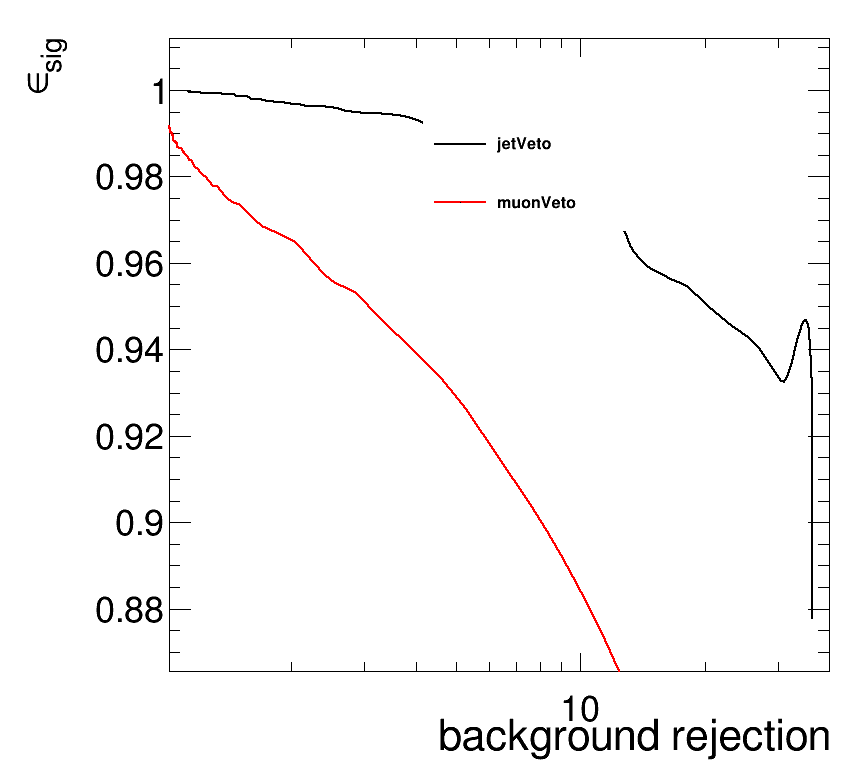

In [52]:
#ROC curve
c = rt.TCanvas('c','c', 850, 800)
leg = rt.TLegend(0.5,0.70,0.85,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
gr = {}


var = [jetVeto, muonVeto]
name = ['jetVeto', 'muonVeto']
legend = ['jetVeto', 'muonVeto']

thre = list(np.arange(0,500,5))
for j in range(len(var)):
    qcd_key = 'bkg'
    sig_k = 'signal'
    eff = {}
    keys = [qcd_key,sig_k]
    for k in keys:
        v = var[j][k]
        eff[k] = []
        for th in thre:
            eff[k].append(1.0*np.sum(weight[k][v<th])/np.sum(weight[k]))
        eff[k] = np.array(eff[k])
#     Plotting ROC curve
    eff[sig_k] = eff[sig_k][eff[qcd_key] > 0]
    eff[qcd_key] = eff[qcd_key][eff[qcd_key] > 0]
#     print(eff[qcd_key])
    print(eff[qcd_key].shape, eff[sig_k].shape)
    gr[name[j]] = create_TGraph(np.reciprocal(eff[qcd_key]),eff[sig_k],axis_title = ['background rejection','#epsilon_{sig}'])
#     gr[name[i]].SetLineColor(std_color_list[int(i/2)])
#     gr[name[i]].SetLineStyle(std_color_list[i%2])
    gr[name[j]].SetLineColor(std_color_list[j])
    gr[name[j]].SetLineStyle(std_color_list[0])
    gr[name[j]].SetLineWidth(2)
    gr[name[j]].GetYaxis().SetTitleOffset(1.5)

    gr[name[j]].GetYaxis().SetRangeUser(0,0.001)
#     gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(gr[name[j]],legend[j])

    gr[name[j]].Draw('ac' if j==0 else 'c')
    c.SetLeftMargin(0.2)
    leg.Draw()
    value = 0.90 #target signal efficiency
    ind = np.abs(eff[sig_k]-value).argmin()
    print(name[j]+" cut", thre[ind], eff[sig_k][ind])
    print(1.0/eff[qcd_key][ind])
#         print(name[i],eff[sig_k][ind])
#         print(thre[ind])

c.SetLogx()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')





29530
5413
muon signal_efficiency 0.9155628
jet signal_efficiency 0.87772655


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_roc/jetVeto.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_roc/jetVeto.C has been generated


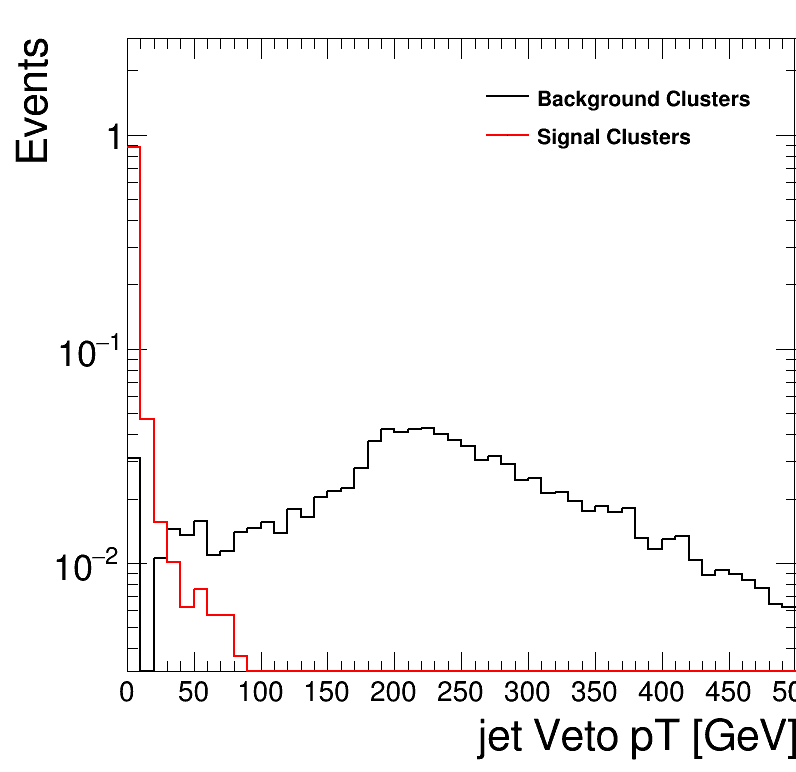

In [85]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.6,0.80,0.90,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

legend = {}
legend['signal'] = 'Signal Clusters'
legend['bkg'] = 'Background Clusters'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'

name = 'jetVeto'
# name = 'muonVeto'
h = {}
rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
for i,k in enumerate(jetVeto.keys()):
    cond = jetVeto[k]<100000000
    print(np.count_nonzero(cond))
    if name == 'jetVeto':
        h[k] = create_TH1D( jetVeto[k], axis_title=['jet Veto pT [GeV]', 'Events'], name=k, binning=[50,0,500],weights = weight[k])
    else:
        h[k] = create_TH1D( muonVeto[k][cond], axis_title=['muon Veto pT [GeV]', 'Events'], name=k, binning=[40,0,100],weights = weight[k][cond])


    h[k].SetLineColor(std_color_list[i])


    h[k].GetXaxis().SetLabelSize(0.04)
#     h[k].SetMinimum(0.001)
    h[k].SetMaximum(0.1)

    h[k].DrawNormalized('hist same')
    leg.AddEntry(h[k],legend[k])

    if k == 'signal':
        print('muon signal_efficiency', np.sum(weight[k][muonVeto[k]<20])/np.sum(weight[k]))
        print('jet signal_efficiency', np.sum(weight[k][jetVeto[k]<10])/np.sum(weight[k]))


c.SetRightMargin(0)
c.SetLogy()
leg.Draw()

c.Draw()
# print(time.time()-start_t)
c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_roc/'+name+'.png')
c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_roc/'+name+'.C')

